In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('/home/cizinsky/garment-texture-completion')
CKPT_ROOT = '/scratch/izar/cizinsky/garment-completion/models/checkpoints'

from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
import pytorch_lightning as pl

from omegaconf import open_dict

import torch
from helpers.pl_module import GarmentInpainterModule
from helpers.dataset import get_dataloaders
from helpers.data_utils import torch_image_to_pil, denormalise_image_torch

import pandas as pd

In [3]:
pl.seed_everything(42);

Seed set to 42


Checking when I last created the dataset:

In [4]:
!stat /scratch/izar/cizinsky/garment-completion/datasets/pbr_maps/dresscode/Batiste_Beige_Argyle/texture_diffuse.png

  File: /scratch/izar/cizinsky/garment-completion/datasets/pbr_maps/dresscode/Batiste_Beige_Argyle/texture_diffuse.png
  Size: 748130    	Blocks: 1472       IO Block: 4194304 regular file
Device: 31h/49d	Inode: 112604467   Links: 1
Access: (0644/-rw-r--r--)  Uid: (278297/cizinsky)   Gid: (30207/sc-ma4-unit)
Access: 2025-06-06 12:15:30.100713000 +0200
Modify: 2025-05-06 23:44:34.000000000 +0200
Change: 2025-06-06 12:15:30.104139766 +0200
 Birth: -


### Inspection of trained models

---


In [5]:
!ls /scratch/izar/cizinsky/garment-completion/models/checkpoints/

apricot-plant-166     eager-energy-111	     lunar-night-196
atomic-frost-171      effortless-pine-170    morning-microwave-118
azure-energy-197      ethereal-rain-174      polar-elevator-172
check_age.py	      faithful-glitter-177   sandy-capybara-119
clean-darkness-225    fanciful-universe-219  stellar-feather-136
cleanup.py	      fast-universe-159      twilight-sponge-160
clear-plant-217       flowing-pyramid-199    valiant-resonance-120
cosmic-cosmos-123     glowing-disco-164      valiant-sun-220
crimson-mountain-224  grateful-terrain-163   winter-wind-173
devoted-glade-198     honest-bird-113	     wise-donkey-178
devout-wind-122       honest-sound-182	     woven-gorge-180


In [6]:
run_name = "valiant-resonance-120"
checkpoint_path = f"{CKPT_ROOT}/{run_name}/last.ckpt"
os.path.exists(checkpoint_path)
if os.path.exists(checkpoint_path):
    print(f"Checkpoint found at {checkpoint_path}")
else:
    print(f"Checkpoint not found at {checkpoint_path}")

Checkpoint found at /scratch/izar/cizinsky/garment-completion/models/checkpoints/valiant-resonance-120/last.ckpt


In [7]:
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)

In [10]:
cfg = checkpoint["hyper_parameters"]

cfg.data.num_workers = 10
cfg.data.batch_size = 10
with open_dict(cfg):
    cfg.data.load_all_pbr_maps = True
    cfg.data.filter_selected_textures = True
trn_dataloader, val_dataloader = get_dataloaders(cfg)

In [12]:
model = GarmentInpainterModule(cfg, trn_dataloader)
model.setup()
model.load_state_dict(checkpoint["state_dict"])
model.eval().cuda()
print("✅ Model loaded!")

--- FYI: Initializing Finetune UNet


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Model loaded!


### Predict diffuse, normal, roughness

In [13]:
model.full_pbr_inference = True

In [14]:
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=False, callbacks=[])

/home/cizinsky/venvs/garment/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/cizinsky/venvs/garment/lib/python3.10/site-pa ...
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
model.model._load_normal_roughness_decoders()

In [18]:
# Predict
outputs = trainer.predict(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

FYI: running full pbr inference using pix2pix


  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
latents = outputs[0]

vae_diffuse = model.model.vae_diffuse
vae_normal = model.model.vae_normal.to(dtype=torch.float32)
vae_roughness = model.model.vae_roughness.to(dtype=torch.float32)

# Decode and save diffuse texture
bsz = latents.shape[0]
pt_diffuse = vae_diffuse.decode(latents / vae_diffuse.config.scaling_factor, return_dict=False)
diffuse = model.inference_pipe.image_processor.postprocess(pt_diffuse[0], output_type="pil", do_denormalize=[True]*bsz)

# Decode and save normal map
pt_normal = vae_normal.decode(latents / vae_normal.config.scaling_factor, return_dict=False)
normal = model.inference_pipe.image_processor.postprocess(pt_normal[0], output_type="pil", do_denormalize=[True]*bsz)

# Decode and save roughness map
pt_roughness = vae_roughness.decode(latents / vae_roughness.config.scaling_factor, return_dict=False)
roughness = model.inference_pipe.image_processor.postprocess(pt_roughness[0], output_type="pil", do_denormalize=[True]*bsz)

In [27]:
batch = next(iter(val_dataloader))
diffuse_imgs = [torch_image_to_pil(denormalise_image_torch(img)) for img in batch["full_diffuse_img"]]
roughness_imgs = [torch_image_to_pil(denormalise_image_torch(img)) for img in batch["roughness_img"]]
normal_imgs = [torch_image_to_pil(denormalise_image_torch(img)) for img in batch["normal_img"]]

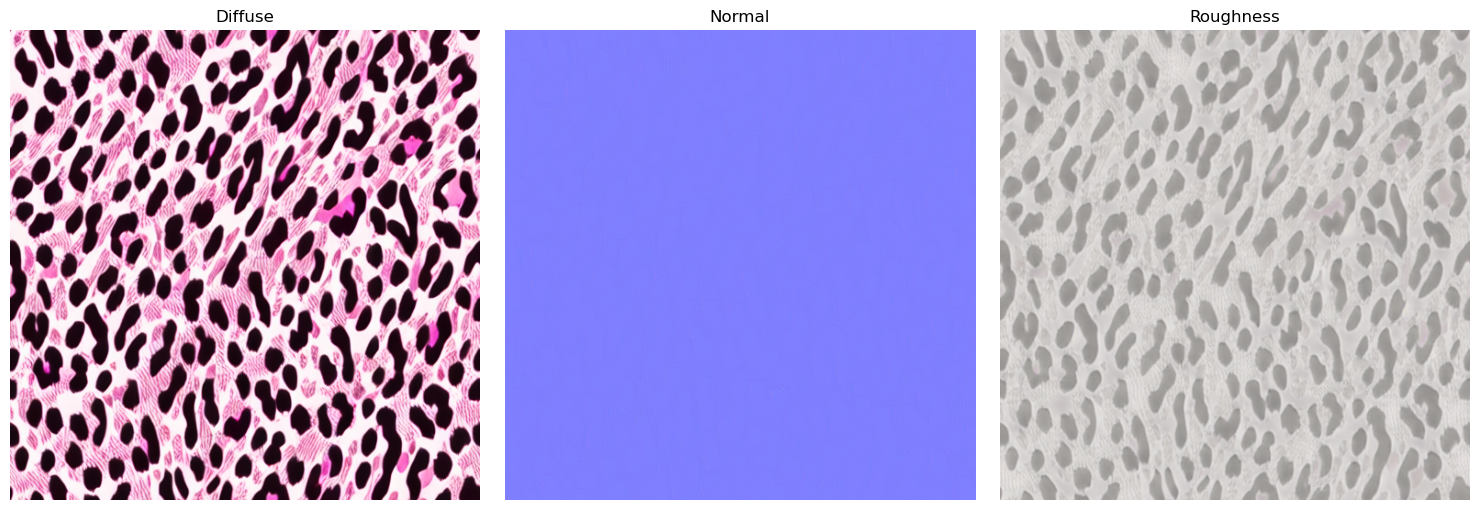

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5))

axs[0].imshow(diffuse_imgs[0])
axs[0].set_title("Diffuse")
axs[0].axis("off")
axs[1].imshow(normal_imgs[0])
axs[1].set_title("Normal")
axs[1].axis("off")
axs[2].imshow(roughness_imgs[0])
axs[2].set_title("Roughness")
axs[2].axis("off")

plt.tight_layout()
plt.show()

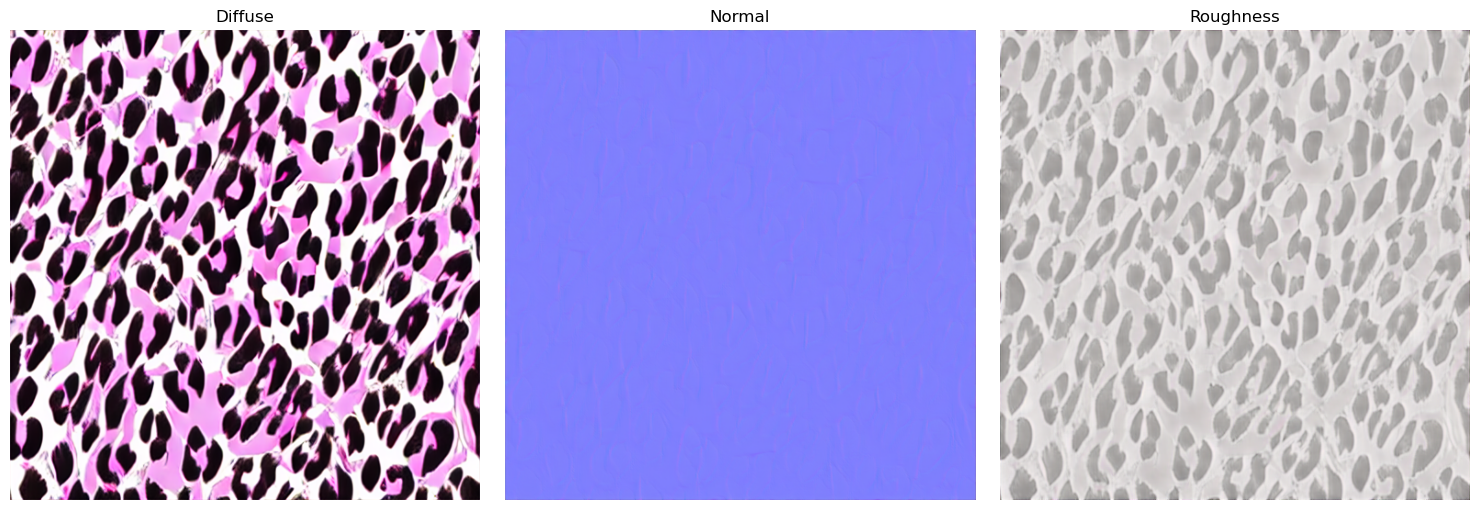

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(diffuse[0])
axs[0].set_title("Diffuse")
axs[0].axis("off")
axs[1].imshow(normal[0])
axs[1].set_title("Normal")
axs[1].axis("off")
axs[2].imshow(roughness[0])
axs[2].set_title("Roughness")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Compute metrics
summary_metrics = {}

for texture_name in ["diffuse", "normal", "roughness"]:

    all_ssim = torch.cat([output[f"{texture_name}_metrics"]["ssim"] for output in outputs])
    all_psnr = torch.cat([output[f"{texture_name}_metrics"]["psnr"] for output in outputs])
    all_lpips = torch.cat([output[f"{texture_name}_metrics"]["lpips"] for output in outputs])

    mean_ssim = all_ssim.mean()
    mean_psnr = all_psnr.mean()
    mean_lpips = all_lpips.mean()

    summary_metrics[f"{texture_name}_ssim"] = mean_ssim
    summary_metrics[f"{texture_name}_psnr"] = mean_psnr
    summary_metrics[f"{texture_name}_lpips"] = mean_lpips

for key, value in summary_metrics.items():
    print(f"{key}: {value}")

### Explore role of inference hyperparameters

In [ ]:
batch = val_batches[0]

In [ ]:
partial_img = batch["partial_diffuse_img"][2].unsqueeze(0).to("cuda")
image_guidance_scale = [2.5, 5.0, 7.5, 10.0]
text_guidance_scale = [2.5, 5.0, 7.5, 10.0]
results = []
for img_scale in image_guidance_scale:
    row_results = []
    for t_scale in text_guidance_scale:
        reconstructed_imgs = model.inference(partial_img, num_inference_steps=50, guidance_scale=t_scale, image_guidance_scale=img_scale)
        row_results.extend(reconstructed_imgs)
    results.append(row_results)


In [ ]:
fig, axs = plt.subplots(
    len(image_guidance_scale),
    len(text_guidance_scale),
    figsize=(5, 5),
    tight_layout=True
)

for i, img_scale in enumerate(image_guidance_scale):
    for j, t_scale in enumerate(text_guidance_scale):
        ax = axs[i, j]
        ax.imshow(results[i][j])
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_edgecolor('white')

        # keep your per-row / per-col numeric labels if you want
        if j == 0:
            ax.set_ylabel(f"{img_scale}", rotation=0, labelpad=10, va='center')
        if i == 0:
            ax.set_title(f"{t_scale}")

# now add the “global” labels
fig.supxlabel("Text guidance scale", fontsize=12)
fig.supylabel("Image guidance scale", fontsize=12)

plt.show()

### Play around with inference hyperparameters

In [ ]:
batch = val_batches[0]

In [ ]:
reconstructed_imgs = model.inference(batch["partial_diffuse_img"][:n].to("cuda"), num_inference_steps=50, guidance_scale=7.5, image_guidance_scale=1.5)

In [20]:
cond_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["partial_diffuse_img"][:n])]
target_images = [torch_image_to_pil(img) for img in denormalise_image_torch(batch["full_diffuse_img"][:n])]

In [ ]:
def plot_images(index):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(cond_images[2])
    axs[0].set_title("Condition")
    axs[0].axis("off")
    axs[1].imshow(results[index])
    img_guidance = image_guidance_scale[index]
    axs[1].set_title(f"Predicted, IMG_GUIDE={img_guidance}")
    axs[1].axis("off")
    axs[2].imshow(target_images[2])
    axs[2].set_title("Target")
    axs[2].axis("off")
    plt.show()

interact(plot_images, index=IntSlider(min=0, max=len(results)-1, step=1));

### Inspect results of the ablation on image vs text guidance

In [6]:
import wandb
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tmp_dir = "/scratch/izar/cizinsky/garment-completion/tmp"

In [ ]:
run = wandb.init()
artifact = run.use_artifact('ludekcizinsky/pbr-generation/run-w5daifhx-best_inference_setup:v0', type='run_table')
artifact.download(tmp_dir)

In [ ]:
!ls {tmp_dir}

In [ ]:
with open(f'{tmp_dir}/best_inference_setup.table.json', 'r') as f:
    table_json = json.load(f)

df = pd.DataFrame(
    table_json['data'],
    columns=table_json['columns']
)

print(f"df.shape: {df.shape}")
df.head()

In [ ]:
metric = "lpips"  # or "psnr", or "lpips"

# determine sort order & arrow
ascending = (metric == "lpips")
arrow = "↓" if metric == "lpips" else "↑"

# ─── 2. AGGREGATE MEAN METRIC ───────────────────────────────────────────────────
grouped = (
    df
    .groupby(['text_scale','img_scale'])
    .agg(mean_val=(metric, 'mean'))
    .reset_index()
)

# ─── 3. MAKE A COMBO LABEL ──────────────────────────────────────────────────────
grouped['combo'] = grouped.apply(
    lambda r: f"({r.text_scale}, {r.img_scale})", axis=1
)

# ─── 4. SORT & FLAG TOP-3 ───────────────────────────────────────────────────────
grouped = grouped.sort_values('mean_val', ascending=ascending).reset_index(drop=True)
grouped['highlight'] = ['Top 3' if i < 3 else 'Other' for i in range(len(grouped))]

# ─── 5. PLOT ───────────────────────────────────────────────────────────────────
sns.set_style("white")

plt.figure(figsize=(12,5))
bar = sns.barplot(
    data=grouped,
    x='combo', y='mean_val',
    hue='highlight', dodge=False,
    palette={'Top 3': "#08023d", 'Other': 'lightgrey'}
)

# fix tick positions & labels
ax = bar
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped['combo'], rotation=45, ha='right')

# clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# labels & title
bar.set_xlabel('Guidance (Text scale, Img scale)')
bar.set_ylabel(f"Mean {metric.upper()}")
bar.set_title(f"Mean (over 100 samples) {metric.upper()} ({arrow}) per guidance configuration")

# legend
bar.legend_.set_title(None)
plt.tight_layout()
plt.show()

In [ ]:
grouped = (
    df
    .groupby(['text_scale','img_scale'])
    .agg(mean_ssim = ('ssim','mean'),
         mean_psnr = ('psnr','mean'),
         mean_lpips= ('lpips','mean'))
    .reset_index()
)

# Copy to avoid modifying original
ranking_df = grouped.copy()

# Compute ranks — higher is better for SSIM and PSNR, lower is better for LPIPS
ranking_df['rank_ssim'] = ranking_df['mean_ssim'].rank(ascending=False)
ranking_df['rank_psnr'] = ranking_df['mean_psnr'].rank(ascending=False)
ranking_df['rank_lpips'] = ranking_df['mean_lpips'].rank(ascending=True)

# Compute average rank
ranking_df['mean_rank'] = ranking_df[['rank_ssim', 'rank_psnr', 'rank_lpips']].mean(axis=1)

# Optional: add label column for clarity
ranking_df['combo'] = ranking_df.apply(lambda r: f"({r.text_scale}, {r.img_scale})", axis=1)

# Sort by mean rank
ranking_df = ranking_df.sort_values('mean_rank')

# Select summary columns
summary = ranking_df[['combo', 'rank_ssim', 'rank_psnr', 'rank_lpips', 'mean_rank']]

summary.iloc[:3]